<a href="https://colab.research.google.com/github/astromad/MyDeepLearningRepo/blob/master/Anomaly_Multi_LSTM_VAE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
# from keras.models import Sequential
# from keras.layers import LSTM,Dense, Dropout,RepeatVector,TimeDistributed, Input
# from keras.layers import RepeatVector
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
modelpath = '/content/drive/MyDrive/ColabData/SAVED-MODELS/'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabData/GE.csv', parse_dates=['Date'], index_col='Date')
print(df.head()) #7 columns, including the Date.

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
1962-01-02  4.691347  4.769536  4.644433  4.675709   0.786456  345317
1962-01-03  4.652252  4.652252  4.613158  4.628796   0.778565  236606
1962-01-04  4.628796  4.667890  4.534969  4.574063   0.769359  294159
1962-01-05  4.574063  4.581882  4.378590  4.456780   0.749632  436442
1962-01-08  4.456780  4.456780  4.316039  4.448961   0.748317  495593


In [ ]:
cols = list(df)[0:5]
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:
df = df.drop('Volume', axis=1)

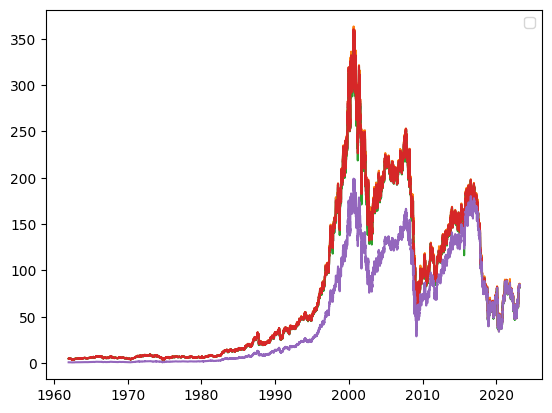

In [ ]:
plt.plot(df)
plt.legend();

In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train1, test1 = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train1.shape, test1.shape)

(14626, 5) (770, 5)


In [ ]:
print(test1.index)

DatetimeIndex(['2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24',
               ...
               '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-21',
               '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', name='Date', length=770, freq=None)


In [ ]:
scaler = StandardScaler()
train = scaler.fit_transform(train1)
test = scaler.fit_transform(test1)
print(train.shape, test.shape)

(14626, 5) (770, 5)


In [ ]:
TIME_STEPS = 1

# reshape to [samples, time_steps, n_features]

trainX = train.reshape(train.shape[0],TIME_STEPS,train.shape[1])
testX = test.reshape(test.shape[0],TIME_STEPS,test.shape[1])

print('trainX shape == {}.'.format(trainX.shape))
print('testX shape == {}.'.format(testX.shape))

trainX shape == (14626, 1, 5).
testX shape == (770, 1, 5).


In [ ]:
dim1= trainX.shape[1]
dim2= trainX.shape[2]
print('TIME_STEPS=', dim1, 'Features', dim2 )
latent_dim =1

TIME_STEPS= 1 Features 5


In [ ]:
# def autoencoder(X):
#   inputs=Input(shape=(X.shape[1], X.shape[2]))
#   L1= LSTM(units=14, return_sequences=False)(inputs)
#   D1=Dropout(rate=0.2)(L1)
#   R=RepeatVector(n=X.shape[1])(D1)
#   L2=LSTM(units=14, return_sequences=True)(R)
#   D2=Dropout(rate=0.2)(L2)
#   output=TimeDistributed(Dense(units=X.shape[2]))(D2)
#   model =  tf.keras.Model(inputs=inputs,outputs=output)
#   return model

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
       z_mean, z_log_var = inputs
       batch = tf.shape(z_mean)[0]
       dim = tf.shape(z_mean)[1]
       epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
       return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:

initializer = tf.keras.initializers.Zeros()

encoder_inputs = keras.Input(shape=(dim1, dim2), name='input')
encoder_output = layers.LSTM(units=64, return_sequences=False, name='EncoderLSTM')(encoder_inputs)
# encoder_output = layers.Dropout(0.2)(encoder_output)
# encoder_output = layers.RepeatVector(n=latent_dim)(encoder_output)
# encoder_output = layers.Flatten()(encoder_output)
# encoder_output = layers.Dense(128, activation="relu")(encoder_output)
# x = layers.Flatten()(encoder_output)
# x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder_output)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer=initializer)(encoder_output)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 1, 5)]               0         []                            
                                                                                                  
 EncoderLSTM (LSTM)          (None, 64)                   17920     ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 1)                    65        ['EncoderLSTM[0][0]']         
                                                                                                  
 z_log_var (Dense)           (None, 1)                    65        ['EncoderLSTM[0][0]']         
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,)) #1256 dim vector
decoder_output = layers.RepeatVector(dim1)(latent_inputs)
decoder_output = layers.LSTM(units=64, return_sequences=True,name='DecoderLSTM')(decoder_output)
decoder_output = layers.Dropout(0.2)(decoder_output)
decoder_output = layers.TimeDistributed(layers.Dense(units=dim2))(decoder_output)
decoder = keras.Model(latent_inputs, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 1)              0         
 r)                                                              
                                                                 
 DecoderLSTM (LSTM)          (None, 1, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 time_distributed (TimeDist  (None, 1, 5)              325       
 ributed)                                                        
                                                                 
Total params: 17221 (67.27 KB)
Trainable params: 17221 (67.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        print("in init")
        self.encoder = encoder
        self.decoder = decoder
        print("set encoder and decoder")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.accuracy = tf.keras.metrics.Accuracy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.accuracy,

        ]

    def train_step(self, data):
        # adapt to taking in the dataloader
        print("in train")
        # print(data)
        input, hat = data
        with tf.GradientTape() as tape:
            # pull out x from data, feed into encoder and decoder
            z_mean, z_log_var, z = self.encoder(input)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(hat, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + .01*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.accuracy.update_state(hat, reconstruction)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"accuracy": self.accuracy.result(),
        }
    def test_step(self, data):
        # Unpack the data
        input, hat = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(input)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(hat, reconstruction), axis=(1)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 0.01*kl_loss
        # Updates the metrics tracking the loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.accuracy.update_state(hat, reconstruction)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"accuracy": self.accuracy.result(),
        }
    # def save(
    #     self, filepath, overwrite=True, include_optimizer=True,
    #     save_format=None, signatures=None, options=None
    # ):
    #     self.save(
    #         filepath=filepath,
    #         overwrite=overwrite,
    #         save_format=save_format,
    #         options=options,
    #         include_optimizer=include_optimizer,
    #         signatures=signatures
    #     )
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

In [ ]:
model = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam(),loss =my_vae_loss)
model.compile(optimizer=keras.optimizers.Adam())

in init
set encoder and decoder


In [ ]:
# model = autoencoder(trainX)
# model.compile(loss='mae', optimizer='adam')
# model.summary()

Learning rate per epoch:


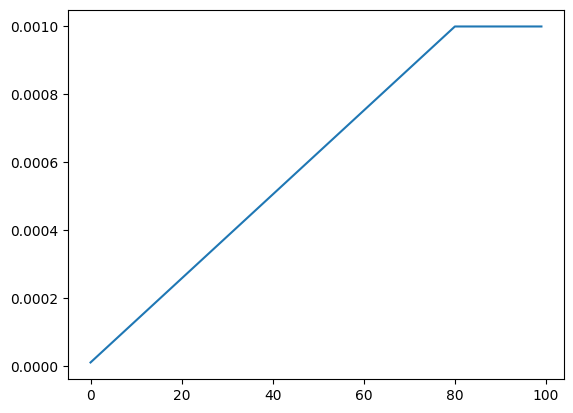

In [ ]:
import math
EPOCHS = 100

start_lr = 0.00001
min_lr = 0.0000001
max_lr = 0.001
rampup_epochs = 80
sustain_epochs = 20
k = 0.8
exp_decay = start_lr * math.exp(-k*EPOCHS)

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 7)
# mc = keras.callbacks.ModelCheckpoint(modelpath+'Anomaly_Multi_LSTM_VAE_Final.model', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history=model.fit(trainX, trainX, epochs=EPOCHS, batch_size=16, validation_split=0.1, verbose=1, callbacks = [es,lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/100
in train
in train
823/823 [==============================] - 23s 15ms/step - loss: 0.9943 - reconstruction_loss: 0.9988 - kl_loss: 0.0014 - val_loss: 1.0214 - val_reconstruction_loss: 1.0214 - val_kl_loss: 1.9249e-05 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.2375000000000002e-05.
Epoch 2/100
823/823 [==============================] - 6s 7ms/step - loss: 0.9918 - reconstruction_loss: 0.9919 - kl_loss: 0.0180 - val_loss: 1.0216 - val_reconstruction_loss: 1.0208 - val_kl_loss: 0.0756 - lr: 2.2375e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.475e-05.
Epoch 3/100
823/823 [==============================] - 4s 5ms/step - loss: 0.9224 - reconstruction_loss: 0.8094 - kl_loss: 0.6191 - val_loss: 0.5875 - val_reconstruction_loss: 0.5689 - val_kl_loss: 1.8610 - lr: 3.4750e-05

Epoch 4: LearningRateScheduler setting learning rate to 4.7124999999999993e-05.
Epoch 4/100
823/

In [ ]:
# history = model.fit(trainX, trainX, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

In [ ]:
model.save(modelpath+'Anomaly_Multi_LSTM_VAE_Final.model')

RecursionError: ignored

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
pred_train = model.predict(trainX)
train_mae_loss = np.mean(np.abs(pred_train - trainX), axis=1)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
pred_test = model.predict(testX)

test_mae_loss = np.mean(np.abs(pred_test - testX), axis=1)

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [ ]:
# def find_anomalies(squared_errors):
#     threshold = np.mean(squared_errors) + np.std(squared_errors)
#     predictions = (squared_errors >= threshold).astype(int)
#     return predictions, threshold

In [ ]:
print(np.mean(train_mae_loss))

In [ ]:
print(np.std(train_mae_loss))

In [ ]:
THRESHOLD = np.mean(train_mae_loss) + np.std(train_mae_loss)
print(THRESHOLD)

In [ ]:
# THRESHOLD = np.max(train_mae_loss)
# print("Reconstruction error threshold: ", THRESHOLD)

In [ ]:
# def find_threshold(model, x_train_scaled):
#   reconstructions = model.predict(x_train_scaled)
#   # provides losses of individual instances
#   reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
#   # threshold for anomaly scores
#   threshold = np.mean(reconstruction_errors.numpy()) \
#       + np.std(reconstruction_errors.numpy())
#   return threshold

In [ ]:
# THRESHOLD = find_threshold(model,trainX)
# print(THRESHOLD)

In [ ]:
# THRESHOLD = 0.13

X_pred = model.predict(testX)
X_pred = X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
test_score_df = pd.DataFrame(index=test1.index)
Xtest = testX.reshape(testX.shape[0],testX.shape[2])
test_score_df['loss'] = np.mean(np.abs(X_pred - Xtest), axis=1)
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test1['Close']
test_score_df['Open'] = test1['Open']
test_score_df['High'] = test1['High']
test_score_df['Low'] = test1['Low']
test_score_df['Adj Close'] = test1['Adj Close']

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

In [ ]:
plt.plot(
  test1[TIME_STEPS:].index,
  test1[TIME_STEPS:]['Open'],
  label='Open price'
);

sns.scatterplot(
  anomalies.Open,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [ ]:
plt.plot(
  test1[TIME_STEPS:].index,
  test1[TIME_STEPS:]['Close'],
  label='close price'
);

sns.scatterplot(
  anomalies['Close'],
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();